In [ ]:
## Notebook env: cell2loc_env (cell2loc_env kernel)
## this notebook performs cell2location to *spatially* deconvolute cells using a reference annotated scRNAseq dataset

In [38]:
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd

import cell2location

from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text for PDFs

In [3]:
results_folder = '/home/ssobti/projects/farnaz_spatial/output_data/cell2location'

# create paths and names to results folders for reference regression and cell2location models
ref_run_name = f'{results_folder}/reference_signatures'
run_name = f'{results_folder}/cell2location_map'

In [4]:
data_folder = '/home/ssobti/projects/farnaz_spatial/data/'

In [6]:
A1_data = sc.read_visium(data_folder + 'count-A1/outs/', count_file='filtered_feature_bc_matrix.h5', load_images=True)
B1_data = sc.read_visium(data_folder + 'count-B1/outs/', count_file='filtered_feature_bc_matrix.h5', load_images=True)
C1_data = sc.read_visium(data_folder + 'count-C1/outs/', count_file='filtered_feature_bc_matrix.h5', load_images=True)
D1_data = sc.read_visium(data_folder + 'count-D1/outs/', count_file='filtered_feature_bc_matrix.h5', load_images=True)

/home/ssobti/miniconda3/envs/cell2loc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/ssobti/miniconda3/envs/cell2loc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/ssobti/miniconda3/envs/cell2loc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/ssobti/miniconda3/envs/cell2loc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [16]:
A1_data.obs['sample'] = list(A1_data.uns['spatial'].keys())[0]
B1_data.obs['sample'] = list(B1_data.uns['spatial'].keys())[0]
C1_data.obs['sample'] = list(C1_data.uns['spatial'].keys())[0]
D1_data.obs['sample'] = list(D1_data.uns['spatial'].keys())[0]

In [19]:
slices = [A1_data, B1_data, C1_data, D1_data]

In [22]:
for slice in slices:
    slice.var['SYMBOL'] = slice.var_names
    slice.var.set_index('gene_ids', drop=True, inplace=True)

In [23]:
# find mitochondria-encoded (MT) genes

for slice in slices:
    slice.var['MT_gene'] = [gene.startswith('MT-') for gene in slice.var['SYMBOL']]
    
    # remove MT genes for spatial mapping (keeping their counts in the object)
    slice.obsm['MT'] = slice[:, slice.var['MT_gene'].values].X.toarray()
    slice = slice[:, ~slice.var['MT_gene'].values]

In [24]:
# Read data
adata_ref = sc.read(data_folder + 'mBAT.h5ad')

In [27]:
adata_ref.var

,_index,features,SYMBOL
0,Xkr4,Xkr4,0
1,Gm1992,Gm1992,1
2,Rp1,Rp1,2
3,Sox17,Sox17,3
4,Mrpl15,Mrpl15,4
...,...,...,...
19766,AC168977.2,AC168977.2,19766
19767,AC168977.1,AC168977.1,19767
19768,AC149090.1,AC149090.1,19768
19769,CAAA01118383.1,CAAA01118383.1,19769


In [28]:
adata_ref.var['SYMBOL'] = adata_ref.var.index
# rename 'GeneID-2' as necessary for your data
## adata_ref.var.set_index('GeneID-2', drop=True, inplace=True)

# delete unnecessary raw slot (to be removed in a future version of the tutorial)
del adata_ref.raw

In [36]:
adata_ref.obs.iloc[1,:]

orig.ident                Sample_1
nUMI                        2483.0
nGene                          926
log10GenesPerUMI          0.873824
mitoRatio                 0.022956
sample                           0
nCount_RNA                  2483.0
nFeature_RNA                   926
S.Score                  -0.069674
G2M.Score                -0.063865
Phase                           G1
CC.Difference             -0.00581
nCount_SCT                  3105.0
nFeature_SCT                   926
integrated_snn_res.0.1           0
integrated_snn_res.0.4           2
integrated_snn_res.0.6           5
integrated_snn_res.0.8           5
integrated_snn_res.1             5
integrated_snn_res.1.2           2
integrated_snn_res.1.4           2
integrated_snn_res.1.8           2
seurat_clusters                  2
cluster_id                       0
_indices                         1
Name: AAACCCAAGCCTGCCA_1, dtype: object

In [37]:
adata_ref.obs

,orig.ident,nUMI,nGene,log10GenesPerUMI,mitoRatio,sample,nCount_RNA,nFeature_RNA,S.Score,G2M.Score,...,integrated_snn_res.0.4,integrated_snn_res.0.6,integrated_snn_res.0.8,integrated_snn_res.1,integrated_snn_res.1.2,integrated_snn_res.1.4,integrated_snn_res.1.8,seurat_clusters,cluster_id,_indices
AAACCCAAGCAAGGAA_1,Sample_1,7534.0,1890,0.845097,0.008628,0,7534.0,1890,0.051525,-0.091907,...,10,17,24,26,29,30,31,31,12,0
AAACCCAAGCCTGCCA_1,Sample_1,2483.0,926,0.873824,0.022956,0,2483.0,926,-0.069674,-0.063865,...,2,5,5,5,2,2,2,2,0,1
AAACCCAAGGGCCAAT_1,Sample_1,4840.0,1868,0.887792,0.017562,0,4839.0,1867,-0.038954,0.075805,...,8,11,10,15,19,19,19,19,8,2
AAACCCACAATACAGA_1,Sample_1,7666.0,2181,0.859466,0.022045,0,7665.0,2180,-0.032397,-0.110683,...,10,23,23,21,26,28,29,29,11,3
AAACCCACACAACGTT_1,Sample_1,9118.0,2657,0.864767,0.035863,0,9118.0,2657,-0.048287,-0.108997,...,10,17,24,26,29,30,31,31,12,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGGTTAGTTTCGAC_16,Sample_16,2588.0,1231,0.905447,0.035162,3,2588.0,1231,0.037950,0.045140,...,2,5,5,5,2,2,2,2,0,94108
TTTGGTTGTACTTGTG_16,Sample_16,2952.0,1243,0.891749,0.033198,3,2952.0,1243,0.034931,-0.052892,...,2,5,5,5,2,2,2,2,0,94109
TTTGGTTTCCCATGGG_16,Sample_16,1805.0,920,0.910121,0.059280,3,1805.0,920,-0.060459,-0.078314,...,0,1,1,1,1,0,0,0,0,94110
TTTGTTGAGGAATGTT_16,Sample_16,2325.0,1066,0.899399,0.075269,3,2325.0,1066,0.079106,-0.027987,...,0,0,0,0,3,1,1,1,0,94111


In [42]:
ref_meta = pd.read_csv('/home/ssobti/projects/farnaz_spatial/data/mBAT_meta.csv', index_col=0)

In [43]:
ref_meta.head()

,orig.ident,nUMI,nGene,log10GenesPerUMI,mitoRatio,sample,nCount_RNA,nFeature_RNA,S.Score,G2M.Score,...,integrated_snn_res.0.1,integrated_snn_res.0.4,integrated_snn_res.0.6,integrated_snn_res.0.8,integrated_snn_res.1,integrated_snn_res.1.2,integrated_snn_res.1.4,integrated_snn_res.1.8,seurat_clusters,cluster_id
AAACCCAAGCAAGGAA_1,Sample_1,7534,1890,0.845097,0.008628,TN,7534,1890,0.051525,-0.091907,...,8,10,17,24,26,29,30,31,31,CD14_cells_cluster30
AAACCCAAGCCTGCCA_1,Sample_1,2483,926,0.873824,0.022956,TN,2483,926,-0.069674,-0.063865,...,0,2,5,5,5,2,2,2,2,B_cells
AAACCCAAGGGCCAAT_1,Sample_1,4840,1868,0.887792,0.017562,TN,4839,1867,-0.038954,0.075805,...,6,8,11,10,15,19,19,19,19,Th1_cells
AAACCCACAATACAGA_1,Sample_1,7666,2181,0.859466,0.022045,TN,7665,2180,-0.032397,-0.110683,...,8,10,23,23,21,26,28,29,29,Macrophages_cluster28
AAACCCACACAACGTT_1,Sample_1,9118,2657,0.864767,0.035863,TN,9118,2657,-0.048287,-0.108997,...,8,10,17,24,26,29,30,31,31,CD14_cells_cluster30


In [44]:
list(ref_meta.index) == list(adata_ref.obs.index)

True

In [46]:
adata_ref.obs['cluster_id'] = ref_meta['cluster_id']

In [47]:
adata_ref.obs

,orig.ident,nUMI,nGene,log10GenesPerUMI,mitoRatio,sample,nCount_RNA,nFeature_RNA,S.Score,G2M.Score,...,integrated_snn_res.0.4,integrated_snn_res.0.6,integrated_snn_res.0.8,integrated_snn_res.1,integrated_snn_res.1.2,integrated_snn_res.1.4,integrated_snn_res.1.8,seurat_clusters,cluster_id,_indices
AAACCCAAGCAAGGAA_1,Sample_1,7534.0,1890,0.845097,0.008628,0,7534.0,1890,0.051525,-0.091907,...,10,17,24,26,29,30,31,31,CD14_cells_cluster30,0
AAACCCAAGCCTGCCA_1,Sample_1,2483.0,926,0.873824,0.022956,0,2483.0,926,-0.069674,-0.063865,...,2,5,5,5,2,2,2,2,B_cells,1
AAACCCAAGGGCCAAT_1,Sample_1,4840.0,1868,0.887792,0.017562,0,4839.0,1867,-0.038954,0.075805,...,8,11,10,15,19,19,19,19,Th1_cells,2
AAACCCACAATACAGA_1,Sample_1,7666.0,2181,0.859466,0.022045,0,7665.0,2180,-0.032397,-0.110683,...,10,23,23,21,26,28,29,29,Macrophages_cluster28,3
AAACCCACACAACGTT_1,Sample_1,9118.0,2657,0.864767,0.035863,0,9118.0,2657,-0.048287,-0.108997,...,10,17,24,26,29,30,31,31,CD14_cells_cluster30,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGGTTAGTTTCGAC_16,Sample_16,2588.0,1231,0.905447,0.035162,3,2588.0,1231,0.037950,0.045140,...,2,5,5,5,2,2,2,2,B_cells,94108
TTTGGTTGTACTTGTG_16,Sample_16,2952.0,1243,0.891749,0.033198,3,2952.0,1243,0.034931,-0.052892,...,2,5,5,5,2,2,2,2,B_cells,94109
TTTGGTTTCCCATGGG_16,Sample_16,1805.0,920,0.910121,0.059280,3,1805.0,920,-0.060459,-0.078314,...,0,1,1,1,1,0,0,0,B_cells,94110
TTTGTTGAGGAATGTT_16,Sample_16,2325.0,1066,0.899399,0.075269,3,2325.0,1066,0.079106,-0.027987,...,0,0,0,0,3,1,1,1,B_cells,94111


/home/ssobti/miniconda3/envs/cell2loc_env/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


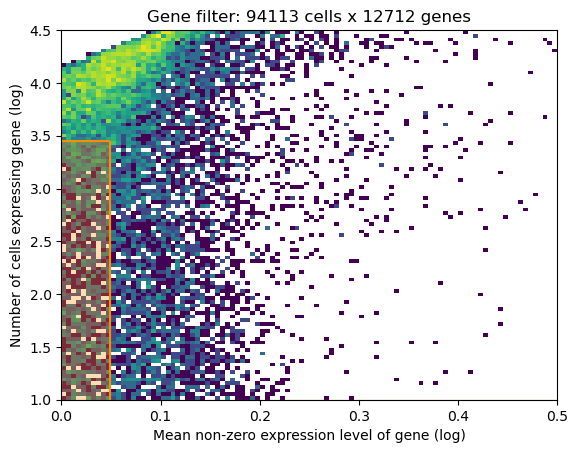

In [29]:
from cell2location.utils.filtering import filter_genes
selected = filter_genes(adata_ref, cell_count_cutoff=5, cell_percentage_cutoff2=0.03, nonz_mean_cutoff=1.12)

# filter the object
adata_ref = adata_ref[:, selected].copy()

In [49]:
## need raw unnormalized count data in adata_ref
# prepare anndata for the regression model
cell2location.models.RegressionModel.setup_anndata(adata=adata_ref,
                        # 10X reaction / sample / batch
                        batch_key='orig.ident',
                        # cell type, covariate used for constructing signatures
                        labels_key='cluster_id',
                        # multiplicative technical effects (platform, 3' vs 5', donor effect)
                       )

/home/ssobti/miniconda3/envs/cell2loc_env/lib/python3.10/site-packages/scvi/data/fields/_layer_field.py:91: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  warnings.warn(


In [50]:
# create the regression model
from cell2location.models import RegressionModel
mod = RegressionModel(adata_ref)

# view anndata_setup as a sanity check
mod.view_anndata_setup()

Anndata setup with scvi-tools version 0.20.0.

Setup via `RegressionModel.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'orig.ident',
│   'labels_key': 'cluster_id',
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │  15   │
│         n_cells          │ 94113 │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │  22   │
│          n_vars          │ 12712 │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │          adata.X          │
│    batch     │ adata.obs['_scvi_batch']  │
│    ind_x     │   adata.obs['_indices']   │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                     batch State Registry                     
┏━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location     ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['orig.ident'] │  Sample_1  │          0          │
│                         │ Sample_10  │          1          │
│                         │ Sample_11  │          2          │
│                         │ Sample_12  │          3          │
│                         │ Sample_13  │          4          │
│                         │ Sample_14  │          5          │
│                         │ Sample_15  │          6          │
│                         │ Sample_16  │          7          │
│                         │  Sample_2  │          8          │
│                         │  Sample_3  │          9          │
│                         │  Sample_4  │         10          │
│                         │  Sample_6  │         11          │
│                         │  Sample_7  │         12          │
│                         │  Sample_8  │         13          │
│                         │  Sample_9  │         14          │
└─────────────────────────┴────────────┴─────────────────────┘

                              labels State Registry                              
┏━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location     ┃          Categories           ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['cluster_id'] │          Adipocytes           │          0          │
│                         │            B_cells            │          1          │
│                         │     CD14_cells_cluster30      │          2          │
│                         │          CD4_T_cells          │          3          │
│                         │          CD8_T_cells          │          4          │
│                         │              ECs              │          5          │
│                         │          Eosinophils          │          6          │
│                         │             ILC2s             │          7          │
│                         │         Lymphatic_EC          │          8          │
│                         │     Macrophages_cluster28     │          9          │
│                         │     Macrophages_cluster33     │         10          │
│                         │        Megakaryocytes         │         11          │
│                         │   Myelinating_Schwann_cells   │         12          │
│                         │           NK_cells            │         13          │
│                         │          Neutrophils          │         14          │
│                         │ Non-myelinating_Schwann_cells │         15          │
│                         │          Pdgfra_APC           │         16          │
│                         │           Pericytes           │         17          │
│                         │           Platelets           │         18          │
│                         │           Th1_cells           │         19          │
│                         │             Tregs             │         20          │
│                         │              VSM              │         21          │
└─────────────────────────┴───────────────────────────────┴─────────────────────┘

In [ ]:
mod.train(max_epochs=250, use_gpu=True)

In [ ]:
mod.plot_history(20)

In [ ]:
# In this section, we export the estimated cell abundance (summary of the posterior distribution).
adata_ref = mod.export_posterior(
    adata_ref, sample_kwargs={'num_samples': 1000, 'batch_size': 2500, 'use_gpu': True}
)

# Save model
mod.save(f"{ref_run_name}", overwrite=True)

# Save anndata object with results
adata_file = f"{ref_run_name}/sc.h5ad"
adata_ref.write(adata_file)
adata_file

In [ ]:
adata_ref = mod.export_posterior(
    adata_ref, use_quantiles=True,
    # choose quantiles
    add_to_obsm=["q05","q50", "q95", "q0001"],
    sample_kwargs={'batch_size': 2500, 'use_gpu': True}
)

In [ ]:
mod.plot_QC()

In [ ]:
adata_file = f"{ref_run_name}/sc.h5ad"
adata_ref = sc.read_h5ad(adata_file)
mod = cell2location.models.RegressionModel.load(f"{ref_run_name}", adata_ref)

In [ ]:
# export estimated expression in each cluster
if 'means_per_cluster_mu_fg' in adata_ref.varm.keys():
    inf_aver = adata_ref.varm['means_per_cluster_mu_fg'][[f'means_per_cluster_mu_fg_{i}'
                                    for i in adata_ref.uns['mod']['factor_names']]].copy()
else:
    inf_aver = adata_ref.var[[f'means_per_cluster_mu_fg_{i}'
                                    for i in adata_ref.uns['mod']['factor_names']]].copy()
inf_aver.columns = adata_ref.uns['mod']['factor_names']
inf_aver.iloc[0:5, 0:5]

In [ ]:
# find shared genes and subset both anndata and reference signatures
intersect = np.intersect1d(adata_vis.var_names, inf_aver.index)
adata_vis = adata_vis[:, intersect].copy()
inf_aver = inf_aver.loc[intersect, :].copy()

# prepare anndata for cell2location model
cell2location.models.Cell2location.setup_anndata(adata=adata_vis, batch_key="sample")

In [ ]:
# create and train the model
mod = cell2location.models.Cell2location(
    adata_vis, cell_state_df=inf_aver,
    # the expected average cell abundance: tissue-dependent
    # hyper-prior which can be estimated from paired histology:
    N_cells_per_location=30,
    # hyperparameter controlling normalisation of
    # within-experiment variation in RNA detection:
    detection_alpha=20
)
mod.view_anndata_setup()

In [ ]:
mod.train(max_epochs=30000,
          # train using full data (batch_size=None)
          batch_size=None,
          # use all data points in training because
          # we need to estimate cell abundance at all locations
          train_size=1,
          use_gpu=True,
         )

# plot ELBO loss history during training, removing first 100 epochs from the plot
mod.plot_history(1000)
plt.legend(labels=['full data training']);

In [ ]:
# In this section, we export the estimated cell abundance (summary of the posterior distribution).
adata_vis = mod.export_posterior(
    adata_vis, sample_kwargs={'num_samples': 1000, 'batch_size': mod.adata.n_obs, 'use_gpu': True}
)

# Save model
mod.save(f"{run_name}", overwrite=True)

# mod = cell2location.models.Cell2location.load(f"{run_name}", adata_vis)

# Save anndata object with results
adata_file = f"{run_name}/sp.h5ad"
adata_vis.write(adata_file)
adata_file

In [ ]:
adata_file = f"{run_name}/sp.h5ad"
adata_vis = sc.read_h5ad(adata_file)
mod = cell2location.models.Cell2location.load(f"{run_name}", adata_vis)

In [ ]:
mod.plot_QC()

In [ ]:
fig = mod.plot_spatial_QC_across_batches()

In [ ]:
# add 5% quantile, representing confident cell abundance, 'at least this amount is present',
# to adata.obs with nice names for plotting
adata_vis.obs[adata_vis.uns['mod']['factor_names']] = adata_vis.obsm['q05_cell_abundance_w_sf']

# select one slide
from cell2location.utils import select_slide
slide = select_slide(adata_vis, 'V1_Human_Lymph_Node')

# plot in spatial coordinates
with mpl.rc_context({'axes.facecolor':  'black',
                     'figure.figsize': [4.5, 5]}):

    sc.pl.spatial(slide, cmap='magma',
                  # show first 8 cell types
                  color=['B_Cycling', 'B_GC_LZ', 'T_CD4+_TfH_GC', 'FDC',
                         'B_naive', 'T_CD4+_naive', 'B_plasma', 'Endo'],
                  ncols=4, size=1.3,
                  img_key='hires',
                  # limit color scale at 99.2% quantile of cell abundance
                  vmin=0, vmax='p99.2'
                 )

In [ ]:
# Now we use cell2location plotter that allows showing multiple cell types in one panel
from cell2location.plt import plot_spatial

# select up to 6 clusters
clust_labels = ['T_CD4+_naive', 'B_naive', 'FDC']
clust_col = ['' + str(i) for i in clust_labels] # in case column names differ from labels

slide = select_slide(adata_vis, 'V1_Human_Lymph_Node')

with mpl.rc_context({'figure.figsize': (15, 15)}):
    fig = plot_spatial(
        adata=slide,
        # labels to show on a plot
        color=clust_col, labels=clust_labels,
        show_img=True,
        # 'fast' (white background) or 'dark_background'
        style='fast',
        # limit color scale at 99.2% quantile of cell abundance
        max_color_quantile=0.992,
        # size of locations (adjust depending on figure size)
        circle_diameter=6,
        colorbar_position='right'
    )